In [1]:
from dotenv import load_dotenv
import pickle
import os

from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFacePipeline
from langchain.tools import tool
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages

from typing_extensions import TypedDict
from typing import Annotated

load_dotenv()  # Считываем креды

/home/tas/.cache/pypoetry/virtualenvs/ai-mas-hse-project-Nc-XwFR1-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
import torch

# Define the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA (NVIDIA GPU) is available.")
elif torch.backends.mps.is_available():  # For Apple Silicon (M1/M2/M3)
    device = torch.device("mps")
    print("MPS (Apple Silicon GPU) is available.")
else:
    device = torch.device("cpu")
    print("No GPU found, running on CPU.")

print(f"Using device: {device}")

CUDA (NVIDIA GPU) is available.
Using device: cuda


In [3]:
# Данная команда позволяет очистить неиспользуемый кэш в GPU
# В моем случае, если я несколько раз инициализирую модель через HuggingFacePipeline, то у меня несколько раз задублируется память на GPU
# Если запустить команду torch.cuda.empty_cache() , то на GPU останется только один инстанс модели, а не несколько

torch.cuda.empty_cache()

# Загружаем датасет с математическими задачами

In [4]:
with open("../data/final_dataset/list_dict_with_tasks.pkl", "rb") as file:
    list_json = pickle.load(file)

## Фиксируем одну конкретную задачу для тестирования бейзлайна

In [5]:
test_task = list_json[47]
test_task

{'id': 32838,
 'topic': 'Алгебра и арифметика',
 'subtopic': 'Задачи на движение',
 'complexity_level': '2',
 'problem': 'Вадим и Лёша спускались с горы. Вадим шёл пешком, а Лёша съезжал на лыжах в семь раз быстрее Вадима. На полпути Лёша упал, сломал лыжи и ногу и пошёл в два раза медленней Вадима. Кто первым спустится с горы?',
 'solution': 'Леша шёл пешком с половины горы столько же времени, сколько Вадим спускался с вершины.',
 'answer': 'Вадим'}

# Hugging Face. Инициализируем модель
* [Huggingface Endpoints](https://docs.langchain.com/oss/python/integrations/llms/huggingface_endpoint#dedicated-endpoint) - здесь описано как пользоваться `HF Endpoints`. Также приведены ссылки с информацией об `inference-providers`. В параграфе `Dedicated Endpoint` описано в каких случаях инференс через endpoint бесплатный, а в каких платный.
* [Inference Providers](https://huggingface.co/docs/inference-providers/index) - исчерпывающая информация о провайдерах.
* [Inference Cost](https://huggingface.co/settings/inference-providers/overview) - здесь показывается информация о том сколько запросов я сделал и с помощью какой LLM. Также показывается сколько денег я должен заплатить за произведенные запросы. Также тут можно посмотреть (переключив ползунок в положение Providers) услугами каких провайдеров я пользуюсь при выполнении запросов к LLM.
* [Billing](https://huggingface.co/settings/billing) - здесь можно посмотреть более подробную сводку о денежных счетах и их оплате. Согласно этой странице, дефолтный HuggingFaceEndpoint, который я использую ниже - бесплатный. Потому что в графе Inference Usage написано 0.00$.
    - Также тут написаны ограничения в графе Hub Rate Limits. Каждый раз, когда я обновляю страницу лимиты сокращаются. Непонимаю почему так, потому что API не пользуюсь в данный момент.
    - А, нет. Все нормально. Я ушел с этой страницы, а потом опять на нее зашел и все стало нормально. Нельзя превышать определенное число запросов за последние 5 минут. В остальном все бесплатно.
* [Inference Endpoints](https://endpoints.huggingface.co/) - сервис для платного инференса (соответственно с большими лимитами)

## HuggingFaceEndpoint
Обращаемся к модели через бесплатный API. Этот метод имеет ряд ограничений по вызовам к модели

In [ ]:
# llm = HuggingFaceEndpoint(
#     repo_id="deepseek-ai/DeepSeek-R1-0528",
#     task="text-generation",
#     max_new_tokens=512,
#     do_sample=False, # При do_sample=True становятся доступны параметры temperature, top_k, top_p
#     repetition_penalty=1.03,
#     provider="auto",  # let Hugging Face choose the best provider for you
# )

# hf_deepseek_model = ChatHuggingFace(llm=llm)

In [ ]:
# response = hf_deepseek_model.invoke("Calculate 3^3")
# print(response.content)

<think>
I need to calculate 3 raised to the power of 3. That's 3^3. I know that exponentiation means multiplying the base number by itself as many times as the exponent says. So for 3^3, I should multiply 3 by itself three times.

Let me write that out: 3 × 3 × 3.

First, 3 times 3 is 9. Then, 9 times 3 is 27. So, 3^3 should be 27.

I recall that 3^2 is 9, and 3^3 is 3 times 3^2, so 3 times 9 is 27. That matches.

Also, 3^1 is 3, 3^2 is 9, 3^3 is 27. It seems consistent.

I think I've got it. So the answer should be 27.

The problem says "calculate 3^3", and I've done that. I don't think there's any trick here. It's straightforward exponentiation.

Just to be thorough, let me consider what exponentiation means. 3^3 = 3 × 3 × 3, which is indeed 27.

In terms of repeated multiplication, it's clear.

I think I'm good.
</think>

To calculate \(3^3\), which means 3 raised to the power of 3, multiply 3 by itself three times:

\[
3 \times 3 \times 3
\]

First, \(3 \times 3 = 9\).

Then, \(9 \

## HuggingFacePipeline
Данный метод скачивает модель на локальный компьютер по следующему пути: `/home/tas/.cache/huggingface/hub`
* Из плюсов: нет никаких ограничений. Все ограничения упираются в лимиты по ресурсам локального компьютера.
* Я выбрал самую легковесную модель: `TinyLlama/TinyLlama-1.1B-Chat-v1.0`. На GPU она занимает 4гб из 12гб.

In [ ]:
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline

llm = HuggingFacePipeline.from_model_id(
    model_id="TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    task="text-generation",
    device=0,
    pipeline_kwargs=dict(
        max_new_tokens=512,
        do_sample=False,  # При do_sample=True становятся доступны параметры temperature, top_k, top_p
        repetition_penalty=1.03,
    ),
)

tiny_lama_model = ChatHuggingFace(llm=llm)
# tiny_lama_model_with_tools = tiny_lama_model.bind_tools([multiply]) # Привязываем Tools к LLM

Device set to use cuda:0


In [10]:
response = tiny_lama_model.invoke("Calculate 3^3")
print(response.content)

<|user|>
Calculate 3^3</s>
<|assistant|>
To calculate 3^3, we need to follow these steps:

1. Multiply the base (3) by the exponent (3).
2. Divide the result by 3 to get the quotient.
3. Multiply the quotient by 3.
4. Add the result to the original base.

So, to calculate 3^3, we would do the following:

1. Multiply 3 by 3.
2. Divide the result by 3.
3. Add the result to 3.

The result is 9, which is the value of 3^3.


# Строим task_solver_llm

Модельки для тестирования запросов:
* `TinyLlama/TinyLlama-1.1B-Chat-v1.0` - мелкая, быстрая, но очень глупая
* `LiquidAI/LFM2-2.6B-Exp` - потяжелее, поумнее, помедленней и плоховато с русским языком
* `HuggingFaceTB/SmolLM3-3B` - не влезает
* `utter-project/EuroLLM-1.7B-Instruct`

In [7]:
torch.cuda.empty_cache()

llm = HuggingFacePipeline.from_model_id(
    model_id="LiquidAI/LFM2-2.6B-Exp",
    task="text-generation",
    device=0,
    pipeline_kwargs=dict(
        max_new_tokens=8192,
        do_sample=False,  # При do_sample=True становятся доступны параметры temperature, top_k, top_p
        repetition_penalty=1.03,
    ),
)

tiny_lama_model = ChatHuggingFace(llm=llm)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [8]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [9]:
# Node
def task_solver_llm(state: MessagesState):
    return {"messages": [tiny_lama_model.invoke(state["messages"])]}

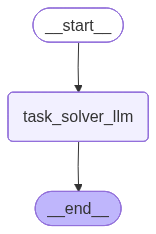

In [10]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("task_solver_llm", task_solver_llm)

builder.add_edge(START, "task_solver_llm")
builder.add_edge("task_solver_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [44]:
test_task = list_json[47]
test_task

{'id': 32838,
 'topic': 'Алгебра и арифметика',
 'subtopic': 'Задачи на движение',
 'complexity_level': '2',
 'problem': 'Вадим и Лёша спускались с горы. Вадим шёл пешком, а Лёша съезжал на лыжах в семь раз быстрее Вадима. На полпути Лёша упал, сломал лыжи и ногу и пошёл в два раза медленней Вадима. Кто первым спустится с горы?',
 'solution': 'Леша шёл пешком с половины горы столько же времени, сколько Вадим спускался с вершины.',
 'answer': 'Вадим'}

In [65]:
##===========Инициализируем промты===========##
system_msg = SystemMessage(
    """
# Роль: ассистент, хорошо понимающий и разбирающийся в математике.

## Твоя задача помочь пользователю "Студент" решить задачу по математике.

## Твое решение должно содержать подробное рассуждение и шаги, которые ты предпринял, чтобы решить задачу. 

## Ты должен обходиться без длительных рассуждений. Вначале напиши план того, как ты будешь решать задачу. Далее действуй согласно описанному плану. Не уходи в бесконечные рассуждения.

## Ответ к задаче необходимо давать после описания решения к задаче в следующем формате: ответ должен находиться между "START_ANSWER" и "END_ANSWER". Т.е. это должно выглядеть следующим образом:

START_ANSWER "Ответ ассистента к задаче" (идет после решения) END_ANSWER

## Важно!!! Твой ответ должен быть коротким и четким и отвечать на вопрос исходной задачи.
"""
)

human_msg = HumanMessage(
    f"Привет, уважаемый ассистент! Я студент. Помоги мне, пожалуйста, решить следующую задачу: {test_task['problem']}",
    name="Студент",
)

# Use with chat models
messages = [system_msg, human_msg]

In [66]:
torch.cuda.empty_cache()
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ System Message ================================


# Роль: ассистент, хорошо понимающий и разбирающийся в математике.

## Твоя задача помочь пользователю "Студент" решить задачу по математике.

## Твое решение должно содержать подробное рассуждение и шаги, которые ты предпринял, чтобы решить задачу. 

## Ты должен обходиться без длительных рассуждений. Вначале напиши план того, как ты будешь решать задачу. Далее действуй согласно описанному плану. Не уходи в бесконечные рассуждения.

## Ответ к задаче необходимо давать после описания решения к задаче в следующем формате: ответ должен находиться между "START_ANSWER" и "END_ANSWER". Т.е. это должно выглядеть следующим образом:

START_ANSWER "Ответ ассистента к задаче" (идет после решения) END_ANSWER

## Важно!!! Твой ответ должен быть коротким и четким и отвечать на вопрос исходной задачи.

================================ Human Message =================================
Name: Студент

Привет, уважаемый асс

In [69]:
answer = messages["messages"][-1].content

start_marker = "START_ANSWER"
end_marker = "END_ANSWER"

start_idx = answer.rfind(start_marker) + len(start_marker)
end_idx = answer.rfind(end_marker)
assist_answer = answer[start_idx:end_idx].strip()
assist_answer

'Вадим.'

# Строим task_reviewer_llm

In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
# Node
def task_solver_llm(state: MessagesState):
    return {"messages": [tiny_lama_model.invoke(state["messages"])]}

In [ ]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("task_solver_llm", task_solver_llm)

builder.add_edge(START, "task_solver_llm")
builder.add_edge("task_solver_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
test_task = list_json[47]
test_task

In [89]:
##===========Инициализируем промты===========##
system_msg_describe = SystemMessage(
    f"""
# Роль: ассистент, проверяющий ответ другого ассистента.

## Твоя задача оценить правильность ответа АССИСТЕНТА №1 и сказать, правильно ли ассистент решил задачу или нет.

## Тебе на вход будет подаваться ответ АССИСТЕНТА №1, а также ground_truth ответ. Однако ground_truth ответ может иногда отсутствовать.

## В случае, если ground_truth ответ имеется, то тебе нужно сравнить ответ АССИСТЕНТА №1 и ground_truth ответ. 

## В случае, если В случае, если ground_truth ответ отсутствует, то тебе нужно сравнить ответ АССИСТЕНТА №1 и ground_truth ответ.

## В качестве ответа напиши "START_ANSWER ПРАВИЛЬНО END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth совпадают. 

## В качестве ответа напиши "START_ANSWER ОШИБКА END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth НЕ совпадают.

## ПИШИ В ОТВЕТЕ ТОЛЬКО "START_ANSWER ПРАВИЛЬНО END_ANSWER" и "START_ANSWER ОШИБКА END_ANSWER".

## Ты должен обходиться без длительных рассуждений. Твоя задача просто сравнить два ответа и сказать правильно ли АССИСТЕНТ №1 решил задачу или нет.
"""
)

system_msg_w_answer = HumanMessage(
    f"Ответ АССИСТЕНТА №1: {assist_answer}. ground_truth = {test_task['answer']}",
    name="АССИСТЕНТ №1",
)

# Use with chat models
messages = [system_msg_describe, system_msg_w_answer]

In [90]:
torch.cuda.empty_cache()
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ System Message ================================


# Роль: ассистент, проверяющий ответ другого ассистента.

## Твоя задача оценить правильность ответа АССИСТЕНТА №1 и сказать, правильно ли ассистент решил задачу или нет.

## Тебе на вход будет подаваться ответ АССИСТЕНТА №1, а также ground_truth ответ. Однако ground_truth ответ может иногда отсутствовать.

## В случае, если ground_truth ответ имеется, то тебе нужно сравнить ответ АССИСТЕНТА №1 и ground_truth ответ. 

## В случае, если В случае, если ground_truth ответ отсутствует, то тебе нужно сравнить ответ АССИСТЕНТА №1 и ground_truth ответ.

## В качестве ответа напиши "START_ANSWER ПРАВИЛЬНО END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth совпадают. 

## В качестве ответа напиши "START_ANSWER ОШИБКА END_ANSWER", если ответ АССИСТЕНТА №1 и ground_truth НЕ совпадают.

## ПИШИ В ОТВЕТЕ ТОЛЬКО "START_ANSWER ПРАВИЛЬНО END_ANSWER" и "START_ANSWER ОШИБКА END_ANSWER".

## Ты должен обходиться без длит

# Объединяем task_solver_llm и task_reviewer_llm

--------------
--------------
--------------
--------------

In [ ]:
# Строим агентный граф
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


from typing import Annotated
from langgraph.graph.message import add_messages


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Node
def task_solver_llm(state: MessagesState):
    pass


def task_reviewer_llm(state: MessagesState):
    pass


from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("task_solver_llm", task_solver_llm)
builder.add_node("task_reviewer_llm", task_reviewer_llm)

builder.add_edge(START, "task_solver_llm")
builder.add_edge("task_solver_llm", "task_reviewer_llm")
builder.add_edge("task_reviewer_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
test_task

{'id': 32838,
 'topic': 'Алгебра и арифметика',
 'subtopic': 'Задачи на движение',
 'complexity_level': '2',
 'problem': 'Вадим и Лёша спускались с горы. Вадим шёл пешком, а Лёша съезжал на лыжах в семь раз быстрее Вадима. На полпути Лёша упал, сломал лыжи и ногу и пошёл в два раза медленней Вадима. Кто первым спустится с горы?',
 'solution': 'Леша шёл пешком с половины горы столько же времени, сколько Вадим спускался с вершины.',
 'answer': 'Вадим'}

In [ ]:
for m in messages["messages"]:
    m.pretty_print()